<a href="https://colab.research.google.com/github/madanmohan-venkatesan/notebooks/blob/main/2011_03567.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.special import gammaln,xlogy,logsumexp
from matplotlib import pyplot as plt
import seaborn as sns

# 2. A sequential multinomial test


In [201]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100

In [202]:
theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)

In [203]:
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)

In [204]:
s_n_null=np.sum(vectors_null,axis=0)
s_n_alt=np.sum(vectors_alt,axis=0)

In [205]:
def beta(v):

  gamma_v=gamma(v)
  numerator=np.prod(v,where=np.isfinite(gamma_v))
  denominator=gamma(np.sum(v,where=np.isfinite(v)))
  result=numerator/denominator
  if np.isnan(result).any():
    return np.array([np.inf])
  else:
    return result


In [206]:
def bf_10(dirichlet_alpha,theta,counts):
  term1_numerator=beta(dirichlet_alpha+counts)
  term1_denominator=beta(dirichlet_alpha)
  term1=term1_numerator/term1_denominator

  term2=1/(theta**counts)
  result=term1*term2

  if np.isnan(result).any() or np.isinf(result).any():
    return np.array([np.inf]*len(result))
  else:
    return result


In [207]:
bf_10(alpha_dirichlet,theta_null,s_n_alt)

array([0., 0.])

For above bf_10, if theta_0 not equal theta then values will go to infinity (reject null hypothesis)
otherwise value is zero(accept null hypothesis)

Hyper paramters to play around with are K and vector size



# Optimization problem for theta

In [208]:
def objective(theta, i,maximize=True):
    """
    Objective function to maximize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to maximize.

    Returns:
    - float: Negative of theta[i] to convert minimization to maximization.
    """
    if maximize:
        return -theta[i]
    else:
      return theta[i]

def constraint_sum(theta):
    """
    Constraint ensuring that the sum of theta is 1.

    Parameters:
    - theta (array): Probability vector (simplex).

    Returns:
    - float: Sum of theta - 1 (should be 0).
    """
    return np.sum(theta) - 1

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Left-hand side of the constraint.
    """

    epsilon = 1e-10
    return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Real simulation

# Without numerical stability

In [209]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100
epsilon = 1e-10

theta_null=np.array([1/CLASSES]*CLASSES) #Simplex
rng = np.random.default_rng()
vectors_null=rng.multinomial(1,theta_null,size=VECTOR_SIZE)
K=100
alpha_dirichlet=K*theta_null
rng = np.random.default_rng()
theta_alt=rng.dirichlet(alpha_dirichlet)
vectors_alt=rng.multinomial(1,theta_alt,size=VECTOR_SIZE)


on_theta_hist_arr=[]
theta_alt_1max_arr=[]
theta_alt_1min_arr=[]

theta_alt_0max_arr=[]
theta_alt_0min_arr=[]

seq_p_val_arr=[]
counter=0
for i in range(0,VECTOR_SIZE,int(VECTOR_SIZE/100)):

  on_theta_prev = None
  vectors_null_i=[]
  vectors_alt_i=[]
  if counter==0:
    on_theta_prev = np.array([1]*CLASSES)
    vectors_null_i=vectors_null[counter]
    vectors_alt_i=vectors_alt[counter]
    on_theta_hist_arr.append(on_theta_prev)
    seq_p_val_arr.append(np.array([1]*CLASSES))
  else:
    vectors_null_i=vectors_null[:i]
    vectors_alt_i=vectors_alt[:i]

  s_n_null=np.sum(vectors_null_i,axis=0)
  s_n_alt=np.sum(vectors_alt_i,axis=0)

  term1_numerator=beta(alpha_dirichlet+s_n_alt)
  term1_denominator=beta(alpha_dirichlet)
  term1=term1_numerator/term1_denominator

  term2=1/(theta_null**s_n_alt)
  on_theta_curr=on_theta_hist_arr[-1]*term1*term2
  print(counter)


  if ((on_theta_curr >= 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("Reject null hypothesis")
    break
  else:
    print("Accept null hypothesis")

  if ((on_theta_curr < 1/0.05).any()) or (np.isnan(on_theta_curr).any()):
    print("proceeding with optimization")
  else:
    print("Reject null hypothesis")
    break

  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms
  u = 0.05  # Example confidence level
  c += np.log(u)

  # Initial guess for theta (uniform distribution)
  initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

  # Constraints
  constraints = [
      {'type': 'eq', 'fun': constraint_sum},
      {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
  ]

  # Bounds to ensure theta remains within [0, 1]
  bounds = [(0, 1) for _ in range(len(theta_alt))]

  # Solve the optimization problem
  result0 = minimize(objective, initial_theta, args=(0,True), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,True), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0max_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1max_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break




  # Solve the optimization problem

  result0 = minimize(objective, initial_theta, args=(0,False), bounds=bounds, constraints=constraints, method='SLSQP')
  result1 = minimize(objective, initial_theta, args=(1,False), bounds=bounds, constraints=constraints, method='SLSQP')

  # Display the result
  if result0.success:
      theta_alt_0min_arr.append(result0.x[0])
  else:
      print("Optimization failed:", result0.message)
      break

  if result1.success:
      theta_alt_1min_arr.append(result1.x[0])
  else:
      print("Optimization failed:", result1.message)
      break
  if counter>0:
    on_theta_hist_arr.append(on_theta_curr)
    # p_val=np.clip(1/on_theta_curr,1/on_theta_curr,seq_p_val_arr[counter-1])
    p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)
    seq_p_val_arr.append(p_val)

  counter+=1

0
Accept null hypothesis
proceeding with optimization
1
Accept null hypothesis
proceeding with optimization
2
Accept null hypothesis
proceeding with optimization
3
Accept null hypothesis
proceeding with optimization
4
Accept null hypothesis
proceeding with optimization
5
Accept null hypothesis
proceeding with optimization
6
Accept null hypothesis
proceeding with optimization
7
Accept null hypothesis
proceeding with optimization
8
Accept null hypothesis
proceeding with optimization
9
Accept null hypothesis
proceeding with optimization
10
Accept null hypothesis
proceeding with optimization
11
Accept null hypothesis
proceeding with optimization
12
Accept null hypothesis
proceeding with optimization
13
Accept null hypothesis
proceeding with optimization
14
Accept null hypothesis
proceeding with optimization
15
Accept null hypothesis
proceeding with optimization
16
Accept null hypothesis
proceeding with optimization
17
Accept null hypothesis
proceeding with optimization
18
Accept null hypot

<ipython-input-209-58b18a80af1a>:120: RuntimeWarning: divide by zero encountered in divide
  p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)
<ipython-input-209-58b18a80af1a>:120: RuntimeWarning: overflow encountered in divide
  p_val=np.minimum(seq_p_val_arr[-1],1/on_theta_curr+epsilon)


20
Accept null hypothesis
proceeding with optimization
21
Accept null hypothesis
proceeding with optimization
22
Accept null hypothesis
proceeding with optimization
23
Accept null hypothesis
proceeding with optimization
24
Accept null hypothesis
proceeding with optimization
25
Accept null hypothesis
proceeding with optimization
26
Accept null hypothesis
proceeding with optimization
27
Accept null hypothesis
proceeding with optimization
28
Accept null hypothesis
proceeding with optimization
29
Accept null hypothesis
proceeding with optimization
30
Accept null hypothesis
proceeding with optimization
31
Accept null hypothesis
proceeding with optimization
32
Accept null hypothesis
proceeding with optimization
33
Accept null hypothesis
proceeding with optimization
34
Accept null hypothesis
proceeding with optimization
35
Accept null hypothesis
proceeding with optimization
36
Accept null hypothesis
proceeding with optimization
37
Accept null hypothesis
proceeding with optimization
38
Accept 

<ipython-input-209-58b18a80af1a>:64: RuntimeWarning: divide by zero encountered in log
  c = np.log(beta(alpha_dirichlet+s_n_alt)) - np.log(beta(alpha_dirichlet))  # Example constant for log Beta terms


# With numerical stability of log liklihood

In [210]:
# Updated objective function
def objective(theta, i, maximize=True):
    """
    Objective function to maximize or minimize theta_i.

    Parameters:
    - theta (array): Probability vector (simplex).
    - i (int): Index of the element to optimize.
    - maximize (bool): True to maximize, False to minimize.

    Returns:
    - float: Optimized theta[i] (negative for maximization).
    """
    if maximize:
        return -theta[i]  # Maximize by minimizing the negative
    else:
        return theta[i]  # Minimize directly

# Constraint for the sum of theta to be 1 (simplex condition)
def constraint_sum(theta):
    return np.sum(theta) - 1

# Log-likelihood constraint with numerical stability

def log_with_numerical_statibility(value):
    """
    Logarithm with numerical stability.

    Parameters:
    - value (float): Input value.

    Returns:
    - float: Logarithm of the input value.
    """

    epsilon = 1e-99  # Small constant for numerical stability
    return np.log(np.clip(value, epsilon, None))
epsilon = 1e-99  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
    """
    Log-likelihood constraint ensuring numerical stability.

    Parameters:
    - theta (array): Probability vector (simplex).
    - Sn (array): Observed count vector S_{n,i}.
    - c (float): Constant c + log u.

    Returns:
    - float: Result of the log-likelihood constraint.
    """
    return np.sum(Sn * log_with_numerical_statibility(theta)) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 100
theta_null = np.array([1 / CLASSES] * CLASSES)  # Initial null hypothesis (simplex)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 100
alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

# Storage for results
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0
NULL_REJECTED = False
# Iterative procedure for calculating bounds
for i in range(0, VECTOR_SIZE, 1):#VECTOR_SIZE // 100):
  if not NULL_REJECTED:
      vectors_null_i = []
      vectors_alt_i = []

      if counter == 0:
          on_theta_prev = np.array([1] * CLASSES)
          vectors_null_i = vectors_null[counter]
          vectors_alt_i = vectors_alt[counter]
          seq_p_val_arr.append(np.array([1] * CLASSES))
      else:
          vectors_null_i = vectors_null[:i]
          vectors_alt_i = vectors_alt[:i]

      s_n_null = np.sum(vectors_null_i, axis=0)
      s_n_alt = np.sum(vectors_alt_i, axis=0)

      # Calculate term1 for the Bayesian update
      term1_numerator = beta(alpha_dirichlet + s_n_alt)
      term1_denominator = beta(alpha_dirichlet)
      term1 = term1_numerator / term1_denominator

      # Ensure numerical stability for the term2 calculation
      term2 = 1 / (theta_null**s_n_alt + epsilon)
      on_theta_curr = seq_p_val_arr[-1] * term1 * term2

      print(f"Iteration {counter}")

      # Check and update p-values
      if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
          print("Reject null hypothesis")
          break
      else:
          print("Accept null hypothesis")
      print(beta(alpha_dirichlet + s_n_alt))
      print(beta(alpha_dirichlet))

      c = log_with_numerical_statibility(beta(alpha_dirichlet + s_n_alt)) - log_with_numerical_statibility(beta(alpha_dirichlet)) + epsilon
      print(c)
      u = 0.05  # Confidence level
      c += log_with_numerical_statibility(u)
      print(c)

      # Initial guess for theta (uniform distribution)
      initial_theta = np.full(len(theta_alt), 1 / len(theta_alt))

      # Constraints
      constraints = [
          {'type': 'eq', 'fun': constraint_sum},
          {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
      ]

      # Bounds to ensure theta remains in the range [0, 1]
      # bounds = [(0, 1) for _ in range(len(theta_alt))]
      bounds = [(epsilon, 1 - epsilon) for _ in range(len(theta_alt))]

      # Maximize theta for both classes
      for j in range(CLASSES):
          result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, constraints=constraints, method='trust-constr')
          if result_max.success:
              if j == 0:
                  theta_alt_0max_arr.append(result_max.x[0])
              else:
                  theta_alt_1max_arr.append(result_max.x[1])
          else:
              print(f"Optimization failed for max class {j}:", result_max.message)
              NULL_REJECTED = True
              break

      # Minimize theta for both classes
      for j in range(CLASSES):
          result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, constraints=constraints, method='trust-constr')
          if result_min.success:
              if j == 0:
                  theta_alt_0min_arr.append(result_min.x[0])
              else:
                  theta_alt_1min_arr.append(result_min.x[1])
          else:
              print(f"Optimization failed for min class {j}:", result_min.message)
              NULL_REJECTED = True
              break

      if counter > 0 and not NULL_REJECTED:
          p_val = np.minimum(seq_p_val_arr[-1], 1 / on_theta_curr)
          seq_p_val_arr.append(p_val)


      counter += 1

  # Plot or further analysis can be done to visualize the non-overlapping nature of CIs


Iteration 0
Accept null hypothesis
2.7594042172419207e-157
2.6787757203136665e-153
1e-99
-2.995732273553991


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


Iteration 1
Accept null hypothesis
2.7323512347199407e-155
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 2
Accept null hypothesis
2.7594042172419207e-157
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 3
Accept null hypothesis
2.7583433159665485e-159
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 4
Accept null hypothesis
2.7305130864317633e-161
2.6787757203136665e-153
1e-99
-2.995732273553991
Iteration 5
Accept null hypothesis
2.675983609113969e-163
2.6787757203136665e-153
1e-99
-2.995732273553991
Optimization failed for max class 0: The maximum number of function evaluations is exceeded.
Optimization failed for min class 0: The maximum number of function evaluations is exceeded.


# With numerical stability of O_n theta and log likelihood

In [211]:
alpha_dirichlet
theta_alt

array([0.45269684, 0.54730316])

In [212]:
def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

In [213]:

# Updated objective function
def objective(theta, i, maximize=True):
    return -theta[i] if maximize else theta[i]

def constraint_sum(theta):
    return np.sum(theta) - 1

epsilon = 1e-10  # Small constant for numerical stability

def constraint_log_likelihood(theta, Sn, c):
  clipped_theta = np.clip(theta, epsilon, 1 - epsilon)
  return np.sum(Sn * np.log(np.clip(theta, epsilon, None))) - c

# Constants
CLASSES = 2
VECTOR_SIZE = 10000
theta_null = np.array([1 / CLASSES] * CLASSES)
rng = np.random.default_rng()
vectors_null = rng.multinomial(1, theta_null, size=VECTOR_SIZE)
K = 45

alpha_dirichlet = K * theta_null
theta_alt = rng.dirichlet(alpha_dirichlet)
vectors_alt = rng.multinomial(1, theta_alt, size=VECTOR_SIZE)

on_theta_hist_arr=[]
theta_alt_1max_arr = []
theta_alt_1min_arr = []
theta_alt_0max_arr = []
theta_alt_0min_arr = []

seq_p_val_arr = []
counter = 0

for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
    break_outer_loop = False
    vectors_null_i = []
    vectors_alt_i = []

    if counter == 0:
        on_theta_prev = np.array([1] * CLASSES)
        vectors_null_i = vectors_null[counter]
        vectors_alt_i = vectors_alt[counter]
        on_theta_hist_arr.append(on_theta_prev)
        seq_p_val_arr.append(np.array([1] * CLASSES))
    else:
        vectors_null_i = vectors_null[:i]
        vectors_alt_i = vectors_alt[:i]

    s_n_null = np.sum(vectors_null_i, axis=0)
    s_n_alt = np.sum(vectors_alt_i, axis=0)

    log_beta_numerator = calculate_log_beta(alpha_dirichlet + s_n_alt)
    log_beta_denominator = calculate_log_beta(alpha_dirichlet)
    log_beta_ratio = log_beta_numerator - log_beta_denominator

    log_theta_term = -np.sum(s_n_alt * np.log(np.clip(theta_null, 1e-10, None)))
    on_theta_curr = log_beta_ratio + log_theta_term + np.log(on_theta_hist_arr[-1])


    print("on_theta",on_theta_curr)
    on_theta_curr=np.exp(on_theta_curr)

    print(f"Iteration {counter}")

    if ((on_theta_curr >= 1 / 0.05).any()) or (np.isnan(on_theta_curr).any()):
        print("Reject null hypothesis")
    else:
        print("Accept null hypothesis")


    def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

    # Replace the calculation of c with the new function
    c = calculate_log_beta(alpha_dirichlet + s_n_alt) - calculate_log_beta(alpha_dirichlet)
    u = 0.05  # Confidence level
    c += np.log(u)

    initial_theta = np.array([1 / CLASSES] * CLASSES)

    constraints = [
        {'type': 'eq', 'fun': constraint_sum},
        {'type': 'ineq', 'fun': constraint_log_likelihood, 'args': (s_n_alt, c)}
    ]

    bounds = [(epsilon, 1 - epsilon) for _ in range(len(theta_alt))]

    # Maximize theta for both classes
    for j in range(CLASSES):
        result_max = minimize(objective, initial_theta, args=(j, True), bounds=bounds, \
                              constraints=constraints, method='SLSQP')
        if result_max.success:
            if j == 0:
                theta_alt_0max_arr.append(result_max.x[0])
            else:
                theta_alt_1max_arr.append(result_max.x[1])
        else:
            print(f"Optimization failed for max class {j}:", result_max.message)
            break_outer_loop = True
            break

    if break_outer_loop:
        break

    # Minimize theta for both classes
    for j in range(CLASSES):
        result_min = minimize(objective, initial_theta, args=(j, False), bounds=bounds, \
                              constraints=constraints, method='SLSQP')
        if result_min.success:
            if j == 0:
                theta_alt_0min_arr.append(result_min.x[0])
            else:
                theta_alt_1min_arr.append(result_min.x[1])
        else:
            print(f"Optimization failed for min class {j}:", result_min.message)
            break_outer_loop = True
            break

    if break_outer_loop:
        break

    if counter > 0 and not break_outer_loop:
        on_theta_hist_arr.append(on_theta_curr)
        p_val = np.minimum(seq_p_val_arr[-1], 1 / (on_theta_curr+epsilon))
        seq_p_val_arr.append(p_val)

    counter += 1


on_theta [-0.02197891 -0.02197891]
Iteration 0
Accept null hypothesis
on_theta [-0.5888666 -0.5888666]
Iteration 1
Accept null hypothesis
on_theta [-1.0388414 -1.0388414]
Iteration 2
Accept null hypothesis
on_theta [-0.75231377 -0.75231377]
Iteration 3
Accept null hypothesis
on_theta [1.14902652 1.14902652]
Iteration 4
Accept null hypothesis
on_theta [3.67030295 3.67030295]
Iteration 5
Reject null hypothesis
on_theta [7.06905734 7.06905734]
Iteration 6
Reject null hypothesis
on_theta [10.64203223 10.64203223]
Iteration 7
Reject null hypothesis
on_theta [13.76646015 13.76646015]
Iteration 8
Reject null hypothesis
on_theta [16.92675638 16.92675638]
Iteration 9
Reject null hypothesis
on_theta [21.80665422 21.80665422]
Iteration 10
Reject null hypothesis
on_theta [28.2861325 28.2861325]
Iteration 11
Reject null hypothesis
on_theta [36.1773135 36.1773135]
Iteration 12
Reject null hypothesis
on_theta [45.000715 45.000715]
Iteration 13
Reject null hypothesis
on_theta [52.36714701 52.36714701]

<ipython-input-213-eca7bdf1666b>:62: RuntimeWarning: overflow encountered in exp
  on_theta_curr=np.exp(on_theta_curr)


on_theta [inf inf]
Iteration 48
Reject null hypothesis
on_theta [inf inf]
Iteration 49
Reject null hypothesis
on_theta [inf inf]
Iteration 50
Reject null hypothesis
on_theta [inf inf]
Iteration 51
Reject null hypothesis
on_theta [inf inf]
Iteration 52
Reject null hypothesis
on_theta [inf inf]
Iteration 53
Reject null hypothesis
on_theta [inf inf]
Iteration 54
Reject null hypothesis
on_theta [inf inf]
Iteration 55
Reject null hypothesis
on_theta [inf inf]
Iteration 56
Reject null hypothesis
on_theta [inf inf]
Iteration 57
Reject null hypothesis
on_theta [inf inf]
Iteration 58
Reject null hypothesis
on_theta [inf inf]
Iteration 59
Reject null hypothesis
on_theta [inf inf]
Iteration 60
Reject null hypothesis
on_theta [inf inf]
Iteration 61
Reject null hypothesis
on_theta [inf inf]
Iteration 62
Reject null hypothesis
on_theta [inf inf]
Iteration 63
Reject null hypothesis
on_theta [inf inf]
Iteration 64
Reject null hypothesis
on_theta [inf inf]
Iteration 65
Reject null hypothesis
on_theta [

[]

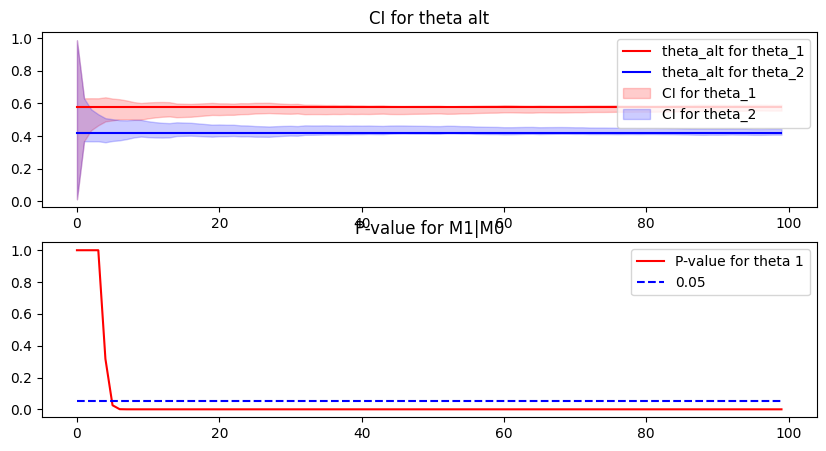

In [214]:
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.title("CI for theta alt")
lenght=len(theta_alt_0min_arr)
plt.plot(range(lenght),[theta_alt[0]]*lenght,color='r',label="theta_alt for theta_1")
plt.plot(range(lenght),[theta_alt[1]]*lenght,color='b',label="theta_alt for theta_2")

plt.fill_between(range(lenght),
                 np.array(theta_alt_0min_arr),
                 np.array(theta_alt_0max_arr), color='r',
                 alpha=0.2, label="CI for theta_1")  # alpha controls transparency


plt.fill_between(range(lenght),
                 np.array(theta_alt_1min_arr),
                 np.array(theta_alt_1max_arr), color='b',
                 alpha=0.2, label="CI for theta_2")  # alpha controls transparency



plt.legend()
plt.subplot(2,1,2)
plt.title("P-value for M1|M0")
plt.plot(range(lenght),np.array(seq_p_val_arr)[:,0],color='r',label="P-value for theta 1")
plt.plot(range(lenght),[0.05]*lenght,'--',color='b',label="0.05")
plt.legend()
plt.plot()


# Inhomogeneous Bernoulli processes

In [215]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=100000

In [216]:
#arm1
assignment_prb_null_arm1=np.array([1/CLASSES]*CLASSES)
K_arm1=45
alpha_dirichlet_arm1=K*assignment_prb_null_arm1
rng = np.random.default_rng()
assignment_prb_alt_arm1=rng.dirichlet(alpha_dirichlet_arm1)
vectors_alt_arm1=rng.multinomial(1,assignment_prb_alt_arm1,size=VECTOR_SIZE)

successful_trials_arm1=vectors_alt_arm1[:,1]
rho_alt_arm1=successful_trials_arm1.sum()/VECTOR_SIZE
mu_class_1_arm1=successful_trials_arm1.mean()
sn_class_1_arm1=successful_trials_arm1.sum()
prob_class_1_arm1=sn_class_1_arm1/successful_trials_arm1.shape[0]
# del_class_1_arm1=np.log(prob_class_1_arm1)/mu_class_1_arm1

In [217]:
#arm2
assignment_prb_null_arm2=np.array([1/CLASSES]*CLASSES)
K_arm2=45
alpha_dirichlet_arm2=K*assignment_prb_null_arm2
rng = np.random.default_rng()
assignment_prb_alt_arm2=rng.dirichlet(alpha_dirichlet_arm2)
vectors_alt_arm2=rng.multinomial(1,assignment_prb_alt_arm2,size=VECTOR_SIZE)

successful_trials_arm2=vectors_alt_arm2[:,1]
rho_alt_arm2=successful_trials_arm2.sum()/VECTOR_SIZE
mu_class_1_arm2=successful_trials_arm2.mean()
sn_class_1_arm2=successful_trials_arm2.sum()
prob_class_1_arm2=sn_class_1_arm2/successful_trials_arm2.shape[0]
# del_class_1_arm2=np.log(prob_class_1_arm2)/mu_class_1_arm2

mu_tot=np.concatenate((successful_trials_arm1,successful_trials_arm2)).mean()

del_class_1_arm1=np.log(prob_class_1_arm1)-mu_tot
del_class_1_arm2=np.log(prob_class_1_arm2)-mu_tot

In [218]:
rho_alt_arm1

0.59333

In [219]:
rho_obs=[rho_alt_arm1,rho_alt_arm2]
deltas=[del_class_1_arm1,del_class_1_arm2]

numerator=rho_obs*np.exp(deltas)
denominator=np.sum(numerator,axis=0)
theta_i=numerator/denominator
print(rho_obs)
print(theta_i)
print(np.sum(rho_obs))

[0.59333, 0.62928]
[0.47062109 0.52937891]
1.22261


In [220]:
def rho_cal(arms):
  arm1=arms[0]
  arm2=arms[1]

  total_vectors=np.concatenate((arm1,arm2))
  size=total_vectors.shape[0]

  count_arm1=arm1.sum()
  count_arm2=arm2.sum()

  rho_arm1=count_arm1/size
  rho_arm2=count_arm2/size
  return np.array([rho_arm1,rho_arm2])

In [221]:
def prob_cal(arms):
  arm1=arms[0]
  arm2=arms[1]

  prob_arm1=arm1.sum()/arm1.shape[0]
  prob_arm2=arm2.sum()/arm2.shape[0]

  return np.array([prob_arm1,prob_arm2])

In [222]:
def mu_tot_cal(arms):
  return arms.mean()

In [223]:
def del_cal(probability,mu):
  return np.log(probability)-mu

In [224]:
def metrics_cal(arms):
  counts=np.sum(arms,axis=1)
  rhos=rho_cal(arms)
  probs=prob_cal(arms)
  mu=mu_tot_cal(arms)
  deltas=del_cal(probs,mu)
  return {"counts":counts,"rhos":rhos,"probs":probs,"mu":mu,"deltas":deltas}

In [225]:
def calculate_log_beta(alpha):
        """
        Numerically stable calculation of log(beta(alpha)).

        Parameters:
        - alpha (array-like): Array of alpha values.

        Returns:
        - float: Logarithm of the beta function value.
        """
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

In [226]:
def objective(a,delta,maximize=True):
    return -np.dot(a,delta) if maximize else np.dot(a,delta)

def penalty_objective(delta, a, c, counts, rhos, eta, maximize=True):
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    constraint_violation = max(0, c - np.sum(counts * (delta + np.log(rhos) - logsumexp(delta + np.log(rhos)))))
    penalty_term = 0.5 * eta * constraint_violation**2
    return obj_value + penalty_term

def penalty_objective_q(q, c, metrics, penalty_coeff=1e6):
    if q <= 0:
        return np.inf  # Ensure q stays positive
    deltas = metrics['deltas']
    counts = metrics['counts']
    rhos = metrics['rhos']
    log_term = np.sum(counts * (deltas + safe_log(rhos) - logsumexp(deltas + safe_log(rhos))))

    # Main constraint violation penalty
    constraint_violation = max(0, c - (np.log(q) + log_term))
    penalty = penalty_coeff * constraint_violation**2
    penalty += penalty_coeff * (max(0,deltas[0] - deltas[1]))**2

    return -np.log(q) + penalty  # Maximize q by minimizing -log(q)
def constraint_q_2(deltas):
    return deltas[1] - max(deltas[0])  # Ensures delta_0 >= delta_i for i > 0


In [227]:
def objective_q(q):
  return -q

In [228]:
def constraint_q_1(q,c,metrics):
  ineq=c - np.log(q) - np.sum(metrics["counts"] * (metrics["deltas"] + np.log(metrics["rhos"]) - logsumexp(metrics["deltas"] + np.log(metrics["rhos"]))))
  return ineq

In [229]:
def constraint_q_2(deltas):
  return deltas[0]-deltas[1]

In [230]:
def constraint(deltas,c,counts,rhos):
  ineq=c-np.sum(counts*(deltas+np.log(rhos)-logsumexp(deltas+np.log(rhos))))
  return ineq

In [254]:
#CONSTANTS
CLASSES=2
VECTOR_SIZE=1000
K=100

#arm1
assignment_prb_null_arm1=np.array([1/CLASSES]*CLASSES)
K_arm1=45
alpha_dirichlet_arm1=K*assignment_prb_null_arm1
rng = np.random.default_rng()
assignment_prb_alt_arm1=rng.dirichlet(alpha_dirichlet_arm1)
vectors_alt_arm1=rng.multinomial(1,assignment_prb_alt_arm1,size=VECTOR_SIZE)

#arm2
assignment_prb_null_arm2=np.array([1/CLASSES]*CLASSES)
K_arm2=45
alpha_dirichlet_arm2=K*assignment_prb_null_arm2
rng = np.random.default_rng()
assignment_prb_alt_arm2=rng.dirichlet(alpha_dirichlet_arm2)
vectors_alt_arm2=rng.multinomial(1,assignment_prb_alt_arm2,size=VECTOR_SIZE)

successful_trials_arm1=vectors_alt_arm1[:,1]
successful_trials_arm2=vectors_alt_arm2[:,1]


contrast_a=np.array([-1,1])

hist=[]
upper_bound=[]
lower_bound=[]
p=[]
counter=0

for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
  if counter == 0:
    counter+=1
    continue
  else:
    vectors_alt_arm1_i=successful_trials_arm1[:i]
    vectors_alt_arm2_i=successful_trials_arm2[:i]

  arms=np.vstack((vectors_alt_arm1_i,vectors_alt_arm2_i))
  metrics=metrics_cal(arms)
  initial_delta = np.random.normal(-0.01, 0.01, size=CLASSES)  # Small random initial guess
  # initial_delta=np.array([1/CLASSES]*CLASSES)
  eta = 1.0


  print(f"Iteration {counter}")

  alpha=K*metrics["rhos"]
  u=0.05
  c=calculate_log_beta(alpha+metrics["counts"])\
  - calculate_log_beta(alpha)\
  + np.log(u)
  # np.random.uniform(-0.1, 0.1, size=CLASSES)
  result_upper = minimize(
    penalty_objective,
    initial_delta,
    args=(contrast_a, c, metrics["counts"], metrics["rhos"], eta, True),  # Arguments for the objective function
    bounds=[(-1,1)],
    method='L-BFGS-B',  # Unconstrained optimization method
    options={'maxiter': 1000}
)
  result_lower = minimize(
    penalty_objective,
    initial_delta,
    args=(contrast_a, c, metrics["counts"], metrics["rhos"], eta, False),  # Arguments for the objective function
    bounds=[(-1,1)],
    method='L-BFGS-B',  # Unconstrained optimization method
    options={'maxiter': 1000}
)
  c=calculate_log_beta(alpha+metrics["counts"])\
  - calculate_log_beta(alpha)
  initial_q = np.random.uniform(0, 1)  # Varied initial guess for q
  constraints = [
        {'type': 'ineq', 'fun': constraint_q_1,'args':(c,metrics)},
        # {'type': 'ineq', 'fun': constraint_q_2, 'args': (metrics["deltas"],)}
        {'type': 'ineq', 'fun': lambda x: constraint_q_2(metrics["deltas"]), 'args': ()}
    ]
  q = minimize(
        penalty_objective_q,
        initial_q,
        args=(c, metrics, 1e6),  # Arguments for the penalty function
        bounds=[(1e-5, None)],  # Ensure q is positive
        method='L-BFGS-B',  # Unconstrained optimization method
        options={'maxiter': 1000, 'disp': True}
    )

  hist.append(metrics)
  if q.success:
    p.append(1/q.x[0])
  else:
    print("q failed")
    print(q.message)
    break
  if result_upper.success:
    upper_bound.append(result_upper.x[0])
  else:
    print(result_upper.message)
    break

  if result_lower.success:
    lower_bound.append(result_lower.x[0])
  else:
    print(result_lower.message)
    break
  counter+=1






Iteration 1
q: [0.76738373], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [0.76738374], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [1.76738373], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [1.76738374], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [2.53476745], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [2.53476746], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [4.30215128], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [4.30215129], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [6.83691913], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [6.83691914], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [11.13906963], log_term: -0.6931471805541691, constraint_violation: 0, penalty: 0.0
q: [11.13906964], log_term: -0.6931471805

In [232]:
# import numpy as np
# from scipy.optimize import minimize
# from scipy.special import gammaln, logsumexp

# # Safe log function for numerical stability
# def safe_log(x, epsilon=1e-10):
#     return np.log(np.clip(x, epsilon, None))

# # Calculate the log Beta function
# def calculate_log_beta(alpha):
#     return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

# # Penalty objective for delta
# def penalty_objective(delta, a, c, counts, rhos, eta, maximize=True):
#     log_term = np.sum(counts * (delta + safe_log(rhos) - logsumexp(delta + safe_log(rhos))))
#     constraint_violation = max(0, c - log_term)
#     penalty = eta * constraint_violation**2
#     obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
#     return obj_value + penalty

# # Penalty-based objective function for q optimization
# def penalty_objective_q(q, c, metrics, penalty_coeff=1e6):
#     if q <= 0:
#         return np.inf  # Ensure q stays positive

#     deltas = metrics['deltas']
#     counts = metrics['counts']
#     rhos = metrics['rhos']
#     log_term = np.sum(counts * (deltas + safe_log(rhos) - logsumexp(deltas + safe_log(rhos))))

#     # Main constraint violation penalty
#     constraint_violation = max(0, c - (np.log(q) + log_term))
#     penalty = penalty_coeff * constraint_violation**2

#     return -np.log(q) + penalty  # Maximize q by minimizing -log(q)

# # Additional constraint for inequality handling
# def constraint_q_2(deltas):
#     return deltas[0] - max(deltas[1:])  # Ensures delta_0 >= delta_i for i > 0

# # Constants
# CLASSES = 2
# VECTOR_SIZE = 1000
# K = 45

# # Generate data for arm1 and arm2
# assignment_prb_null_arm1 = np.array([1 / CLASSES] * CLASSES)
# alpha_dirichlet_arm1 = K * assignment_prb_null_arm1
# rng = np.random.default_rng()
# assignment_prb_alt_arm1 = rng.dirichlet(alpha_dirichlet_arm1)
# vectors_alt_arm1 = rng.multinomial(1, assignment_prb_alt_arm1, size=VECTOR_SIZE)

# assignment_prb_null_arm2 = np.array([1 / CLASSES] * CLASSES)
# alpha_dirichlet_arm2 = K * assignment_prb_null_arm2
# assignment_prb_alt_arm2 = rng.dirichlet(alpha_dirichlet_arm2)
# vectors_alt_arm2 = rng.multinomial(1, assignment_prb_alt_arm2, size=VECTOR_SIZE)

# successful_trials_arm1 = vectors_alt_arm1[:, 1]
# successful_trials_arm2 = vectors_alt_arm2[:, 1]

# contrast_a = np.array([-1, 1])
# hist = []
# upper_bound = []
# lower_bound = []
# p = []
# counter = 0

# for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
#     if counter == 0:
#         counter += 1
#         continue
#     else:
#         vectors_alt_arm1_i = successful_trials_arm1[:i]
#         vectors_alt_arm2_i = successful_trials_arm2[:i]

#     arms = np.vstack((vectors_alt_arm1_i, vectors_alt_arm2_i))
#     metrics = metrics_cal(arms)  # Assuming metrics_cal is defined elsewhere
#     initial_delta = np.random.normal(-0.01, 0.01, size=CLASSES)
#     eta = 1.0

#     print(f"Iteration {counter}")

#     alpha = K * metrics["rhos"]
#     u = 0.05
#     c = calculate_log_beta(alpha + metrics["counts"]) - calculate_log_beta(alpha) + np.log(u)

#     # Optimize for q using the penalty method
#     initial_q = np.random.uniform(0.5, 1.5)  # Varied initial guess for q
#     q = minimize(
#         penalty_objective_q,
#         initial_q,
#         args=(c, metrics, 1e6),  # Arguments for the penalty function
#         bounds=[(1e-5, None)],  # Ensure q is positive
#         method='L-BFGS-B',  # Unconstrained optimization method
#         options={'maxiter': 1000, 'disp': True}
#     )

#     hist.append(metrics)
#     if q.success:
#         p.append(1 / q.x[0])
#     else:
#         print("q optimization failed")
#         print(q.message)
#         break

#     counter += 1


In [233]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp

# Safe log function for numerical stability
def safe_log(x, epsilon=1e-10):
    return np.log(np.clip(x, epsilon, None))

# Calculate the log Beta function
def calculate_log_beta(alpha):
    return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))

# Penalty objective for delta
def penalty_objective(delta, a, c, counts, rhos, eta, maximize=True):
    log_term = np.sum(counts * (delta + safe_log(rhos) - logsumexp(delta + safe_log(rhos))))
    constraint_violation = max(0, c - log_term)
    penalty = eta * constraint_violation**2
    obj_value = -np.dot(a, delta) if maximize else np.dot(a, delta)
    return obj_value + penalty

# Penalty-based objective function for q optimization
def penalty_objective_q(q, c, metrics, penalty_coeff=1e6):
    if q <= 0:
        return np.inf  # Ensure q stays positive

    deltas = metrics['deltas']
    counts = metrics['counts']
    rhos = metrics['rhos']

    # Normalize counts to prevent numerical instability
    counts = counts / (np.sum(counts) + 1e-10)

    log_term = np.sum(counts * (deltas + safe_log(rhos) - logsumexp(deltas + safe_log(rhos))))

    # Main constraint violation penalty
    constraint_violation = max(0, c - (np.log(q) + log_term))
    penalty = penalty_coeff * constraint_violation**2
    penalty += penalty_coeff * (max(0,deltas[0] - deltas[1]))**2


    # Debug print statements for detailed tracing
    print(f"q: {q}, log_term: {log_term}, constraint_violation: {constraint_violation}, penalty: {penalty}")

    return -np.log(q) + penalty  # Maximize q by minimizing -log(q)

# Additional constraint for inequality handling
def constraint_q_2(deltas):
    return deltas[0] - max(deltas[1:])  # Ensures delta_0 >= delta_i for i > 0

# Constants
CLASSES = 2
VECTOR_SIZE = 10000  # Adjusted to a larger size for testing
K = 1

# Generate data for arm1 and arm2
assignment_prb_null_arm1 = np.array([1 / CLASSES] * CLASSES)
alpha_dirichlet_arm1 = 100 * assignment_prb_null_arm1
rng = np.random.default_rng()
assignment_prb_alt_arm1 = rng.dirichlet(alpha_dirichlet_arm1)
vectors_alt_arm1 = rng.multinomial(1, assignment_prb_alt_arm1, size=VECTOR_SIZE)

assignment_prb_null_arm2 = np.array([1 / CLASSES] * CLASSES)
alpha_dirichlet_arm2 = 1 * assignment_prb_null_arm2
assignment_prb_alt_arm2 = rng.dirichlet(alpha_dirichlet_arm2)
vectors_alt_arm2 = rng.multinomial(1, assignment_prb_alt_arm2, size=VECTOR_SIZE)

successful_trials_arm1 = vectors_alt_arm1[:, 1]
successful_trials_arm2 = vectors_alt_arm2[:, 1]

contrast_a = np.array([-1, 1])
hist = []
upper_bound = []
lower_bound = []
p = []
counter = 0

for i in range(0, VECTOR_SIZE, VECTOR_SIZE // 100):
    if counter == 0:
        counter += 1
        continue
    else:
        vectors_alt_arm1_i = successful_trials_arm1[:i]
        vectors_alt_arm2_i = successful_trials_arm2[:i]

    arms = np.vstack((vectors_alt_arm1_i, vectors_alt_arm2_i))
    metrics = metrics_cal(arms)  # Assuming metrics_cal is defined elsewhere
    initial_delta = np.random.normal(-0.01, 0.01, size=CLASSES)
    eta = 1.0

    print(f"Iteration {counter}")

    alpha = K * metrics["rhos"]
    u = 0.05
    c = calculate_log_beta(alpha + metrics["counts"]) - calculate_log_beta(alpha) + np.log(u)

    # Optimize for q using the penalty method
    initial_q = np.random.uniform(0.5, 1.5)  # Varied initial guess for q
    q = minimize(
        penalty_objective_q,
        initial_q,
        args=(c, metrics, 1e6),  # Arguments for the penalty function
        bounds=[(0, None)],  # Ensure q is positive
        method='L-BFGS-B',  # Unconstrained optimization method
        options={'maxiter': 1000, 'disp': True}
    )

    hist.append(metrics)
    if q.success:
        p_value = 1 / q.x[0]
        print(f"Optimized q: {q.x[0]}, p-value: {p_value}")
        p.append(p_value)
    else:
        print("q optimization failed")
        print(q.message)
        break

    counter += 1


Streaming output truncated to the last 5000 lines.
q: [1410.54773574], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [2282.13095409], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [2282.1309541], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [3693.02058644], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [3693.02058645], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [5973.18580352], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [5973.18580353], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [9663.76249507], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [9663.76249508], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [15628.77521783], log_term: -0.6824903468124272, constraint_violation: 0, penalty: 0.0
q: [15628.77521784], log_term: -0.6824903468124272, constra

In [234]:
metrics

{'counts': array([4441, 8692]),
 'rhos': array([0.22429293, 0.4389899 ]),
 'probs': array([0.44858586, 0.8779798 ]),
 'mu': 0.6632828282828283,
 'deltas': array([-1.46493801, -0.79341452])}

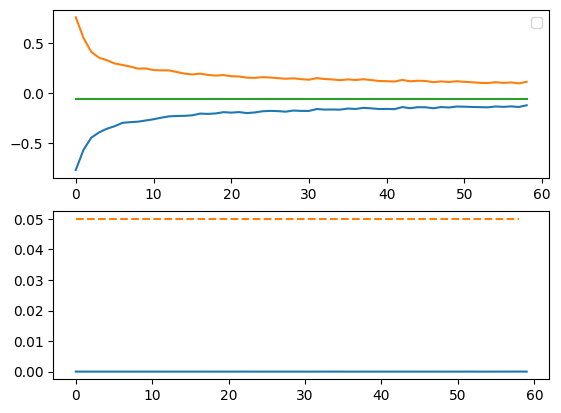

In [255]:
plt.subplot(2,1,1)
del1=metrics["deltas"][0]
del2=metrics["deltas"][1]
diff=(del2)-(del1)
plt.plot(upper_bound)
plt.plot(lower_bound)
plt.plot([diff]*len(upper_bound))
plt.legend()
plt.subplot(2,1,2)
plt.plot(p)
plt.plot([0.05]*len(upper_bound),"--")
plt.show()

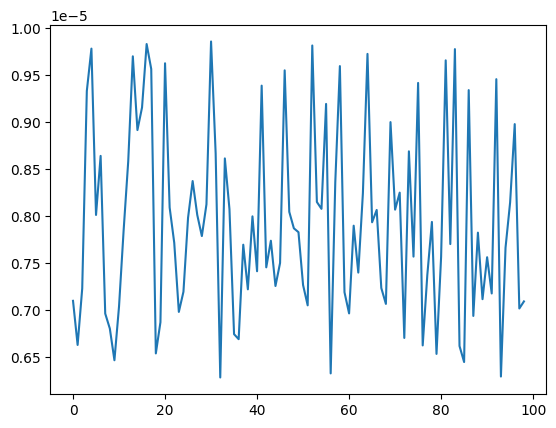

In [236]:
plt.plot(p)
plt.plot([0.05]*len(upper_bound),"--")
plt.show()